This code was adapted from the following github: https://github.com/justjoshtings/satellite_image_segmentation

In [2]:
# !pip install tensorflow tensorflow_addons tensorflow_datasets tensorflow_hub numpy matplotlib seaborn sklearn pystac pystac_client

##Setup:

Change the abspath_curr to reflect your drive/directories, which hase the data

In [1]:
# from google.colab import drive
# import sys

# # Mount Google Drive
# drive.mount('/content/drive')

# # Get the absolute path of the current folder
# abspath_curr = '/content/drive/My Drive/Application Development Final proj'


import os

# Get the absolute path of the current folder
abspath_curr = os.getcwd()
# abspath_curr = r'C:\Users\ohits\OneDrive\AP_CNN_FinalProject'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import os
import shutil
import math

from PIL import Image
import glob
import cv2
import pickle
import copy

import warnings
import random


import requests

import tempfile
from pathlib import Path
import itertools as it
from urllib.parse import urljoin

from pystac import Item
from pystac.extensions.eo import EOExtension
from pystac.extensions.label import LabelRelType
from pystac.extensions.scientific import ScientificExtension
from pystac_client import Client

import tempfile

# Import keras and model specific objects
from tensorflow.keras import layers
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dropout , concatenate , UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model


In [3]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [4]:
# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [5]:
# Random Seed

# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [9]:
# Check what version of TF we are using
print(tf.version.VERSION)

2.12.0


In [10]:
# Print the number of GPUs available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Test to see if GPU is found and connected
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('\nFound GPU at: {}'.format(device_name))
  print('\nCurrently using:')
  !nvidia-smi -L

Num GPUs Available:  0
GPU device not found


List variable

## TO-DO:

Organize data based on Emma's directoires

#### **Set Up Data Directories**

The data is aviable for download in the following link:
https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset?resource=download
it is a litle bit heavy but the directories are already organized. It is necessary to make sure the directories of images and masks between **train**, **valid**, and **test** are setup correctly.




In [6]:
meta_df = pd.read_csv(abspath_curr + "/data/metadata.csv")
class_df = pd.read_csv(abspath_curr + "/data/class_dict.csv")

print(class_df.head(10))

print(meta_df.head())

               name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0
   image_id  split        sat_image_path              mask_path
0    100694  train  train/100694_sat.jpg  train/100694_mask.png
1    102122  train  train/102122_sat.jpg  train/102122_mask.png
2     10233  train   train/10233_sat.jpg   train/10233_mask.png
3    103665  train  train/103665_sat.jpg  train/103665_mask.png
4    103730  train  train/103730_sat.jpg  train/103730_mask.png


In [12]:
# 'Valid' does not have masks so let's merge that with the train and take a subset of train for validation
meta_df[meta_df['split'] == 'valid'].head()

,image_id,split,sat_image_path,mask_path
803,105036,valid,valid/105036_sat.jpg,NaN
804,107780,valid,valid/107780_sat.jpg,NaN
805,108490,valid,valid/108490_sat.jpg,NaN
806,127801,valid,valid/127801_sat.jpg,NaN
807,128240,valid,valid/128240_sat.jpg,NaN


In [13]:
# Update meta_df => with the actual path
meta_df['sat_image_path'] = meta_df['sat_image_path'].str.replace('valid/', 'test/')
meta_df['split'] = meta_df['split'].str.replace('valid', 'test')

Here we can change the variable *0.9 for a one thet the user can change
(Christina)

In [14]:
# Create divides for train, test, val
train_df = meta_df[meta_df['split'] == 'train']

#### Here we can change the variable *0.9 for a one that the user can change
###########Christina
train_num_samples = round(len(train_df)*0.75)
val_num_samples = len(train_df) - train_num_samples

In [15]:
#shuffle all rows of DataFrame
train_df = train_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
train_df.head()

,image_id,split,sat_image_path,mask_path
0,315352,train,train/315352_sat.jpg,train/315352_mask.png
1,427774,train,train/427774_sat.jpg,train/427774_mask.png
2,28689,train,train/28689_sat.jpg,train/28689_mask.png
3,661864,train,train/661864_sat.jpg,train/661864_mask.png
4,675849,train,train/675849_sat.jpg,train/675849_mask.png


these two lines of code split the shuffled training dataset into a training portion and a validation portion by updating the 'split' column values accordingly. The first train_num_samples rows are marked as 'train', and the remaining rows are marked as 'valid'.

In [16]:
train_df['split'].iloc[:train_num_samples] = 'train'
train_df['split'].iloc[train_num_samples:] = 'valid'

In [17]:
non_train_df = meta_df[meta_df['split'] != 'train']

train_df['sat_image_path'] = train_df['sat_image_path'].str.replace('train/', 'train/train_images/images/')
train_df['mask_path'] = train_df['mask_path'].str.replace('train/', 'train/train_masks/masks/')

meta_df = pd.concat([train_df, non_train_df], axis=0)
meta_df.head()

,image_id,split,sat_image_path,mask_path
0,315352,train,train/train_images/images/315352_sat.jpg,train/train_masks/masks/315352_mask.png
1,427774,train,train/train_images/images/427774_sat.jpg,train/train_masks/masks/427774_mask.png
2,28689,train,train/train_images/images/28689_sat.jpg,train/train_masks/masks/28689_mask.png
3,661864,train,train/train_images/images/661864_sat.jpg,train/train_masks/masks/661864_mask.png
4,675849,train,train/train_images/images/675849_sat.jpg,train/train_masks/masks/675849_mask.png


Now we have labeled validation data to work with.

The code snippet is extracting and displaying the initial rows of the DataFrame meta_df that correspond to the validation split,

In [18]:
meta_df[meta_df['split'] == 'valid'].head()

,image_id,split,sat_image_path,mask_path
602,246378,valid,train/train_images/images/246378_sat.jpg,train/train_masks/masks/246378_mask.png
603,550312,valid,train/train_images/images/550312_sat.jpg,train/train_masks/masks/550312_mask.png
604,803958,valid,train/train_images/images/803958_sat.jpg,train/train_masks/masks/803958_mask.png
605,786226,valid,train/train_images/images/786226_sat.jpg,train/train_masks/masks/786226_mask.png
606,919051,valid,train/train_images/images/919051_sat.jpg,train/train_masks/masks/919051_mask.png


Final dataset split redy to process will be this:

In [19]:
print('Samples in train: ', len(meta_df[meta_df['split'] == 'train']))
print('Samples in validation: ', len(meta_df[meta_df['split'] == 'valid']))
print('Samples in test: ', len(meta_df[meta_df['split'] == 'test']))

Samples in train:  602
Samples in validation:  201
Samples in test:  343


The levels have the following values
This is what our classes look like.

In [20]:
class_df = pd.read_csv(abspath_curr + "/data/class_dict.csv")

class_df.head(10)

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


#### **Move Files**

Move images to their correct directories based on train, validation, and testing splits.

In [18]:
def make_directory(path):
  """
  Function to make directory if not exits

  Paramater:
    path - path of directory

  Return:
    None
  """
  directory = os.path.dirname(path)
  if not os.path.exists(directory):
    os.makedirs(directory)

  return


In [22]:
# Make directories => inside the directories allready have
make_directory(abspath_curr + '/data/train/train_images/images/')
make_directory(abspath_curr + '/data/train/train_masks/masks/')

make_directory(abspath_curr + '/data/val/val_images/images/')
make_directory(abspath_curr + '/data/val/val_masks/masks/')
make_directory(abspath_curr + '/result/class_distribution/')


In [23]:
def move_files(list_filenames, source_path, target_path):
  """
  Function to move files from source to target directory based on a list of filenames within source

  Parameters:
    list_filesname - list of filenames
    source_path - path of source directory
    target_path - path of target directory

  Return:
    None
  """
  for file_name in list_filenames:
      try:
        shutil.move(os.path.join(source_path, file_name), os.path.join(target_path, file_name))
      except FileNotFoundError:
        continue

In [24]:
# List of test, val filenames =>  variables to copy in the other folders crated

train_sat_img_path = meta_df[meta_df['split'] == 'train']['sat_image_path']

train_sat_img_path = train_sat_img_path.str.replace('train/train_images/images/', '')



new_val_sat_img_path = meta_df[meta_df['split'] == 'valid']['sat_image_path']

new_val_sat_img_path = new_val_sat_img_path.str.replace('val/val_images/images/', '')



train_msk_img_path = meta_df[meta_df['split'] == 'train']['mask_path']

train_msk_img_path = train_msk_img_path.str.replace('train/train_masks/masks/', '')



new_val_msk_img_path = meta_df[meta_df['split'] == 'valid']['mask_path']

new_val_msk_img_path = new_val_msk_img_path.str.replace('val/val_masks/masks/', '')



old_val_img_path = os.listdir(abspath_curr + '/data/valid/')

#té un menú contextual

The following code defines a function named folder_is_empty that checks whether a given folder (path) contains certain image files. The function can be used to determine if a folder is "empty" based on the presence of specific image file types.

In [25]:
def folder_is_empty(path, img_types=['.png', '.jpg', '.tif']):
  """
  Function to check if a filepath is empty

  Parameters:
    path - filepath to image or mask data

  Return:
    True if empty, False if not

  We can use this function like this:
    if not False:
      do X
    else:
      do Y

  this will do X.
  """

  if any(list(map(lambda x: True if x in ''.join(os.listdir(path)) else False, img_types))):
    return False
  else:
    return True

In [26]:
# Moves files from main folders of train, val to sub-directories

# Old validation goes to test
if not folder_is_empty(abspath_curr + '/data/valid'):
  # image
  move_files(old_val_img_path, abspath_curr + '/data/valid/', abspath_curr + '/data/test')

# Split old train to new train and new val
if not folder_is_empty(abspath_curr + '/data/train'):
  # train_image
  move_files(train_sat_img_path, abspath_curr + '/data/train/', abspath_curr + '/data/train/train_images/images')
  # train_mask
  move_files(train_msk_img_path, abspath_curr + '/data/train/', abspath_curr + '/data/train/train_masks/masks')

  # val_image
  move_files(new_val_sat_img_path, abspath_curr + '/data/train/', abspath_curr + '/data/val/val_images/images')
  # val_mask
  move_files(new_val_msk_img_path, abspath_curr + '/data/train/', abspath_curr + '/data/val/val_masks/masks')



In [27]:
# Check if images got moved right
print('Train Images: ', len(os.listdir(abspath_curr + '/data/train/train_images/images')))
print('Train Masks: ',len(os.listdir(abspath_curr + '/data/train/train_masks/masks')))

print('Val Images: ',len(os.listdir(abspath_curr + '/data/val/val_images/images')))
print('Val Masks: ',len(os.listdir(abspath_curr + '/data/val/val_masks/masks')))

print('Test Images: ',len(os.listdir(abspath_curr + '/data/test')))
print('Test Masks: ',len(os.listdir(abspath_curr + '/data/test')))

Train Images:  602
Train Masks:  602
Val Images:  0
Val Masks:  0
Test Images:  343
Test Masks:  343


#### **Convert masks to .png to prevent loss and generally preferred over .jpg**

Masks are generally preferred to be in .png format. We convert to .png if the masks were not already in .png format.

In [28]:
def convert_file_type(filepath, dest_file_type):
  """
  Function to convert all files in a directory to a defined file type

  Parameters:
    filepath - filepath
    dest_file_type - str of dest_file_type ('.png')

  Return:
    None
  """
  for mask_file in os.listdir(filepath):
    try:
        # Attempt to open an image file
        image = cv2.imread(filepath + '/' + mask_file)
    except IOError as e:
        # Report error, and then skip to the next argument
        print ("Problem opening", mask_file, ":", e)
        continue

    # Split our original filename into name and extension
    (name, extension) = os.path.splitext(mask_file)

    # Save new file type
    cv2.imwrite(filepath + '/' + name + dest_file_type, image)

    # Delete original copy
    os.remove(filepath + '/' + mask_file)

In [29]:
# If .jpg or .tif found in masks directories, convert them into .png type

if not folder_is_empty(abspath_curr + '/data/train/train_masks/masks', img_types=['.jpg', '.tif']):
  convert_file_type(abspath_curr + '/data/train/train_masks/masks', '.png')

if not folder_is_empty(abspath_curr + '/data/val/val_masks/masks', img_types=['.jpg', '.tif']):
  convert_file_type(abspath_curr + '/data/val/val_masks/masks', '.png')

#### **Cut up images to have more samples and smaller training features**

Since the original images are 2448x2448x3, it requires a lot of computing resources to be loaded at a time to train just one image. Instead, we can cut up the images into smaller patches to reduce the amount of computing resources needed to load one image into memory and train.

In [30]:
def cut_images(filepath, dest_filepath, n_sub_images):
  """
  Function to convert all masks to only forest labeled masks

  Parameters:
    filepath - source filepath
    dest_filepath - destination filepath
    n_sub_images - number of images to cut

  Return:
    None
  """
  for mask_file in os.listdir(filepath):
    try:
        # Attempt to open an image file
        image = plt.imread(filepath + '/' + mask_file)
    except IOError as e:
        # Report error, and then skip to the next argument
        print ("Problem opening", mask_file, ":", e)
        continue

    pixels = int(image.shape[0] / math.sqrt(n_sub_images))

    count = 0

    for r in range(0,image.shape[0],pixels):
      for c in range(0,image.shape[1],pixels):

        filename = mask_file.split('.')[0]
        extension = mask_file.split('.')[1]

        # Save new file type
        plt.imsave(dest_filepath + filename + '_{}.'.format(count) + extension, image[r:r+pixels, c:c+pixels,:])

        count+=1

    os.remove(filepath + '/' + mask_file)
  print('Images of: {}x{}'.format(pixels, pixels))

In [31]:
run_cut_images = False

if run_cut_images:
  # Images
  cut_images(abspath_curr + '/data/train/train_images/images/', abspath_curr + '/data/train/train_images/images/', 16)
  cut_images(abspath_curr + '/data/val/val_images/images/', abspath_curr + '/data/val/val_images/images/', 16)
  cut_images(abspath_curr + '/data/test/', abspath_curr + '/data/test/', 16)

  # Masks
  cut_images(abspath_curr + '/data/train/train_masks/masks/', abspath_curr + '/data/train/train_masks/masks/', 16)
  cut_images(abspath_curr + '/data/val/val_masks/masks/', abspath_curr + '/data/val/val_masks/masks/', 16)

In [32]:
# Check if images got moved right
print('Train Images: ', len(os.listdir(abspath_curr + '/data/train/train_images/images')))
print('Train Masks: ',len(os.listdir(abspath_curr + '/data/train/train_masks/masks')))

print('Val Images: ',len(os.listdir(abspath_curr + '/data/val/val_images/images')))
print('Val Masks: ',len(os.listdir(abspath_curr + '/data/val/val_masks/masks')))

print('Test Images: ',len(os.listdir(abspath_curr + '/data/test')))

Train Images:  602
Train Masks:  602
Val Images:  0
Val Masks:  0
Test Images:  343


#### **Class Weights**

Let's take a look at the class imbalance/balance. We will look at the number of pixels that belongs to each class.

In [33]:
def get_pixels_class_weights(path, class_map):
  """
  Function to go to specified mask path, go through each image
  and count number of pixels that belong to each class

  Parameters:
    paths: path to images
    class_map: class_df

  Return:
    pixel_counts: np array of pixel counts in order of class appearance in class_df
  """
  images = os.listdir(path)

  pixel_counts = np.zeros(len(class_map))

  # Iterate through image
  for image in images:
    img = plt.imread(path+image)

    # Iterate through class_map
    class_counter = 0
    for index, row in class_df.iterrows():
        new_img = copy.deepcopy(img[::,::,::])

        R = new_img[::,::,0]
        G = new_img[::,::,1]
        B = new_img[::,::,2]

        #method to check where rgb = 0, 255, 255 etc, subset it & np.count_nonzero
        count = (new_img[(R == row['r']/255) & (G == row['g']/255) & (B == row['b']/255)].size)/3

        # add count to array
        pixel_counts[class_counter]+=count

        class_counter+=1

  return pixel_counts

def pixels_class_weights(paths_list, save_path, class_map=None):
  """
  Function to get pixels class weights for classes

  Parameters:
    paths_list: list of paths
    class_map: class_df

  Return:
    class_pixels: pandas df of classes and percentage of pixels belonging to that class
  """
  class_pixels = class_map.copy()
  class_pixels['Pixels_Count'] = 0

  for counter, path in enumerate(paths_list):
    pixels_count_array = get_pixels_class_weights(path, class_map)
    # hstack each array to df, sum columns and drop stacked column
    class_pixels['Pixels_Count_{}'.format(counter)] = pixels_count_array.tolist()
    class_pixels['Pixels_Count'] = class_pixels['Pixels_Count'] + class_pixels['Pixels_Count_{}'.format(counter)]
    # drop rgb cols in df
    class_pixels.drop('Pixels_Count_{}'.format(counter), axis=1, inplace=True)

  # Percentage of pixels in each class
  class_pixels['Weights'] = round(class_pixels['Pixels_Count']/class_pixels['Pixels_Count'].sum(), 2)

  # Weighting to use for calculating loss
  class_pixels['True Weights'] = (1 / class_pixels['Pixels_Count']) * class_pixels['Pixels_Count'].sum()/class_pixels.shape[0]
  class_pixels.loc[6,'True Weights'] = 0.001

  # Save results
  make_directory(save_path)
  class_pixels.to_csv(save_path+'class_pixels_count.csv', index=False)

  return class_pixels


Here are the number and percentage of pixels that belong to each class. Note that the highest is the agriculture class where 58% of the pixels belong to this class. We will see how this affects our model's performance.

In [25]:
####in orther to run the 'run_class_pixels' True to not create the file False
run_class_pixels = False

if run_class_pixels:
  class_pixels = pixels_class_weights([abspath_curr + '/data/train/train_masks/masks/', ],
                                      abspath_curr + '/result/class_distribution/',
                                      class_map=class_df)

else:
  class_pixels = pd.read_csv(abspath_curr + '/result/class_distribution/class_pixels_count.csv')

print(class_pixels.head(10))

               name    r    g    b  Pixels_Count  Weights  True Weights
0        urban_land    0  255  255  3.946269e+08     0.11      1.305974
1  agriculture_land  255  255    0  2.076072e+09     0.58      0.248244
2         rangeland  255    0  255  3.074413e+08     0.09      1.676328
3       forest_land    0  255    0  4.096262e+08     0.11      1.258153
4             water    0    0  255  1.326458e+08     0.04      3.885330
5       barren_land  255  255  255  2.851897e+08     0.08      1.807122
6           unknown    0    0    0  2.005654e+06     0.00      0.001000


## **Load Data**

#### **Sanity Check**

In [35]:
#Sanity check, view few mages
def peek_images(sample_images, sample_masks=None, encode=None, color_scale=None, file_name=None, mask_name=None, predict=None, model=None, sample_images2=None, model_alt=None):
  """
  Function to plot a randomly selected training set (or validation set if given validation filepaths)

  Parameters:
    sample_images: image in np array
    sample_masks: mask in np array
    encode: Boolean to set encoding type 'uint8' or not
    color_scale: set to 'gray' to set grayscale
    file_name: filename to display in image plot tile
    mask_name: filename to display in mask plot tile
    predict: Boolean, set to True if want to show prediction plots
    model: instance of Keras model object to use .predict() on

  Return:
    None
  """
  image_number = random.randint(0, sample_images.shape[0]-1)

  plt.figure(figsize=(12, 6))

  # Original Image
  if predict is not None and model is not None and model_alt is not None:
    plt.subplot(141)
  elif predict is not None and model is not None and model_alt is None:
    plt.subplot(131)
  else:
    plt.subplot(121)

  if encode == 'uint8':
    plt.imshow(sample_images.astype(('uint8')))
  else:
    plt.imshow(sample_images)
  plt.title('Original:\n{}'.format(file_name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  # Mask
  if predict is not None and model is not None and model_alt is not None:
    plt.subplot(142)
  elif predict is not None and model is not None and model_alt is None:
    plt.subplot(132)
  else:
    plt.subplot(122)

  if encode == 'uint8':
    if color_scale == 'gray':
      plt.imshow(sample_masks.astype(('uint8')), cmap='gray')
    else:
      plt.imshow(sample_masks.astype(('uint8')))
  else:
    if color_scale == 'gray':
      plt.imshow(sample_masks, cmap='gray')
    else:
      plt.imshow(sample_masks)
  plt.title('Ground Truth Mask:\n{}'.format(mask_name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  if predict is not None and model is not None and model_alt is not None:
    plt.subplot(143)
  if predict is not None and model is not None and model_alt is None:
    plt.subplot(133)
    # Prediction

  if predict is not None:
    # Turn (612, 612, 3) to (1, 612, 612, 3)
    if len(sample_images.shape) == 3:
      sample_images = np.expand_dims(sample_images, axis=0)

    # Predict image
    predicted_image = model.predict(sample_images)
    predicted_image = predicted_image[0,::,::,::]
    # Reverse one hot encode predicted mask
    predicted_image_decoded = reverse_one_hot_encode(predicted_image)


    if encode == 'uint8':
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
      else:
        plt.imshow(predicted_image_decoded.astype(('uint8')))
    else:
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded, cmap='gray')
      else:
        plt.imshow(predicted_image_decoded)
    plt.title('Predicted Mask {}:'.format(model.name), fontdict = {'fontsize' : 8})
    plt.axis('off')

  if predict is not None and model is not None and model_alt is not None:
    # Prediction #2

    # Turn (612, 612, 3) to (1, 612, 612, 3)
    if len(sample_images2.shape) == 3:
      sample_images2 = np.expand_dims(sample_images2, axis=0)

    # Predict image
    predicted_image = model_alt.predict(sample_images2)
    predicted_image = predicted_image[0,::,::,::]
    # Reverse one hot encode predicted mask
    predicted_image_decoded = reverse_one_hot_encode(predicted_image)

    plt.subplot(144)
    if encode == 'uint8':
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
      else:
        plt.imshow(predicted_image_decoded.astype(('uint8')))
    else:
      if color_scale == 'gray':
        plt.imshow(predicted_image_decoded, cmap='gray')
      else:
        plt.imshow(predicted_image_decoded)
    plt.title('Predicted Mask {}:'.format(model_alt.name), fontdict = {'fontsize' : 8})
    plt.axis('off')

  plt.show()


In [36]:
def peek_masks_breakdown(sample_images, sample_masks=None, encode=None, color_scale=None, file_name=None, mask_name=None, predict=None, model=None):
  """
  Function to plot a randomly selected prediction mask and breakdown channels

  Parameters:
    sample_images: image in np array
    sample_masks: mask in np array
    encode: Boolean to set encoding type 'uint8' or not
    color_scale: set to 'gray' to set grayscale
    file_name: filename to display in image plot tile
    mask_name: filename to display in mask plot tile
    predict: Boolean, set to True if want to show prediction plots
    model: instance of Keras model object to use .predict() on

  Return:
    None
  """
  image_number = random.randint(0, sample_images.shape[0]-1)

  plt.figure(figsize=(12, 6))

  # Turn (612, 612, 3) to (1, 612, 612, 3)
  if len(sample_images.shape) == 3:
    sample_images = np.expand_dims(sample_images, axis=0)

  # Predict image
  predicted_image = model.predict(sample_images)
  predicted_image = predicted_image[0,::,::,::]
  predicted_image = rescale(predicted_image)

  # Reverse one hot encode predicted mask
  predicted_image_decoded = reverse_one_hot_encode(predicted_image)
  predicted_image_decoded = rescale(predicted_image_decoded)

  # Predicted
  plt.subplot(4,2,1)

  if encode == 'uint8':
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
    else:
      plt.imshow(predicted_image_decoded.astype(('uint8')))
  else:
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded, cmap='gray')
    else:
      plt.imshow(predicted_image_decoded)
  plt.title('Predicted Mask {}:'.format(model.name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  labels = ['Urban Land, Light Blue:',
            'Agriculture Land, Yellow:',
            'Rangeland, Purple:',
            'Forest Land, Green:',
            'Water, Blue:',
            'Barren Land, White:',
            'Unknown, Black:'
            ]

  all_colored_channel_activations = 0

  for i in range(predicted_image.shape[-1]-1):
    # Channels
    plt.subplot(4,2,i+2)
    plt.imshow(predicted_image[::,::,i])

    pixels_activated = np.count_nonzero(predicted_image[::,::,i] >= 1)
    percent_pixels_activated = round(pixels_activated / np.size(predicted_image[::,::,i]) * 100, 5)

    all_colored_channel_activations+=percent_pixels_activated

    plt.title(labels[i] + '{}% Pixels Activated'.format(percent_pixels_activated), fontdict = {'fontsize' : 8})
    plt.axis('off')

  # Unknown Channel
  plt.subplot(4,2,8)
  plt.imshow(predicted_image[::,::,6])

  plt.title(labels[-1] + '{}% Pixels Activated'.format(round(100 - all_colored_channel_activations, 5)), fontdict = {'fontsize' : 8})
  plt.axis('off')

  plt.show()


In [37]:
#Sanity check, view few mages
def peek_images_test(sample_images, sample_masks=None, encode=None, color_scale=None, file_name=None, mask_name=None, predict=None, model=None):
  """
  Function to plot a randomly selected testing set

  Parameters:
    sample_images: image in np array
    sample_masks: mask in np array
    encode: Boolean to set encoding type 'uint8' or not
    color_scale: set to 'gray' to set grayscale
    file_name: filename to display in image plot tile
    mask_name: filename to display in mask plot tile
    predict: Boolean, set to True if want to show prediction plots
    model: instance of Keras model object to use .predict() on

  Return:
    None
  """
  image_number = random.randint(0, sample_images.shape[0]-1)

  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(121)

  if encode == 'uint8':
    plt.imshow(sample_images.astype(('uint8')))
  else:
    plt.imshow(sample_images)
  plt.title('Original:\n{}'.format(file_name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  # Prediction
  plt.subplot(122)

  # Turn (612, 612, 3) to (1, 612, 612, 3)
  if len(sample_images.shape) == 3:
    sample_images = np.expand_dims(sample_images, axis=0)

  # Predict image
  predicted_image = model.predict(sample_images)
  predicted_image = predicted_image[0,::,::,::]
  # Reverse one hot encode predicted mask
  predicted_image_decoded = reverse_one_hot_encode(predicted_image)

  if encode == 'uint8':
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded.astype(('uint8')), cmap='gray')
    else:
      plt.imshow(predicted_image_decoded.astype(('uint8')))
  else:
    if color_scale == 'gray':
      plt.imshow(predicted_image_decoded, cmap='gray')
    else:
      plt.imshow(predicted_image_decoded)
  plt.title('Predicted Mask {}:'.format(model.name), fontdict = {'fontsize' : 8})
  plt.axis('off')

  plt.show()


In [38]:
def sanity_check(sample_images, sample_masks=None, encode=None, color_scale=None, predict=None, model=None, model_alt=None, predicted_breakdown=None, imsize=None, imsize_alt=None):
  """
  Function to get a training set (or validation set if given validation filepaths) and calls plotting functions

  Parameters:
    sample_images: image in np array
    sample_masks: mask in np array
    encode: Boolean to set encoding type 'uint8' or not
    color_scale: set to 'gray' to set grayscale
    file_name: filename to display in image plot tile
    mask_name: filename to display in mask plot tile
    predict: Boolean, set to True if want to show prediction plots
    model: instance of Keras model object to use .predict() on

  Return:
    None
  """
  image_number = random.randint(0, len(os.listdir(sample_images))-1)

  file_name = sorted(os.listdir(sample_images))[image_number]
  image_file = sorted(os.listdir(sample_images))[image_number]
  image = np.array(plt.imread(sample_images + image_file))

  if sample_masks is not None:
    mask_name = sorted(os.listdir(sample_masks))[image_number]
    mask_file = sorted(os.listdir(sample_masks))[image_number]
    mask = np.array(plt.imread(sample_masks + mask_file))

  if imsize is not None and sample_masks is not None:
    image =  cv2.resize(image, (imsize, imsize))
    mask =  cv2.resize(mask, (imsize, imsize))
  elif imsize is not None and sample_masks is None:
    image =  cv2.resize(image, (imsize, imsize))

  image1 = copy.deepcopy(image)

  if model_alt:
    image2 = copy.deepcopy(image)
    if imsize_alt is not None and sample_masks is not None:
      image2 =  cv2.resize(image, (imsize_alt, imsize_alt))
      mask =  cv2.resize(mask, (imsize_alt, imsize_alt))
    elif imsize_alt is not None and sample_masks is None:
      image2 =  cv2.resize(image, (imsize_alt, imsize_alt))
  else:
    image2 = None

  # Compare image and mask only
  if predicted_breakdown is None and sample_masks is not None:
    peek_images(sample_images=image1, sample_masks=mask, encode=encode, color_scale=color_scale, file_name=file_name, mask_name=mask_name, predict=predict, model=model)
  # Compare original image and mask with predicted mask for model 1 or with model 1 and model 2
  elif predicted_breakdown is not None and sample_masks is not None:
    image1 = preprocessor_images(image1)
    mask = preprocessor_images(mask)
    if image2 is not None:
      image2 = preprocessor_images(image2)
    peek_images(sample_images=image1, sample_masks=mask, encode=encode, color_scale=color_scale, file_name=file_name, mask_name=mask_name, predict=predict, model=model, sample_images2=image2, model_alt=model_alt)
    peek_masks_breakdown(sample_images=image1, sample_masks=mask, encode=encode, color_scale=color_scale, file_name=file_name, mask_name=mask_name, predict=predict, model=model)
  # Test data, no masks
  elif sample_masks is None:
    image1 = preprocessor_images(image1)
    peek_images_test(sample_images=image1, encode=encode, color_scale=color_scale, file_name=file_name, predict=predict, model=model)
    # peek_masks_breakdown(sample_images=image, encode=encode, color_scale=color_scale, file_name=file_name, predict=predict, model=model)


Run this cell below multiple times to visually inspect random images and their associated masks as a sanity check.

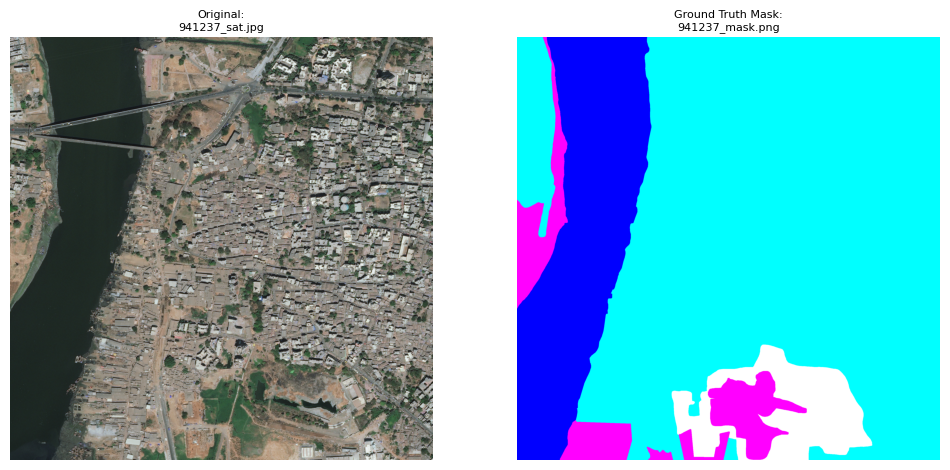

In [39]:
# Randomly selects image and mask from sample set and plot just to double check everything is working correctly.
# Run this a few times to check on a few different image and mask sets
sanity_check(abspath_curr + '/data/train/train_images/images/' , abspath_curr + '/data/train/train_masks/masks/')

#### **Set up generators, image preprocessing, and loading data to generators**

In [7]:
def binarize(img, threshold=128):
  """
  Function to binarize images at some threshold pixel value

  Parameters:
    img: image in numpy matrix
    threshold: pixel threshold to binarize

  Return:
    img: binarized image in numpy matrix
  """
  # Binarize the image
  if np.max(img) > 1:
    img[img > threshold] = 255
    img[img <= threshold] = 0
  else:
    img[img > (threshold/255)] = 255
    img[img <= (threshold/255)] = 0

  return img

In [8]:
def rescale(img):
  """
  Function to rescale image from 0 to 255 to between 0 and 1.

  Parameters:
    img: image in numpy matrix

  Return:
    img: rescaled image in numpy matrix
  """
  if np.max(img) > 1:
    img = np.multiply(img, 1./255)

  return img

In [9]:
def one_hot_encode(img, class_map=None):
  """
  Function to one hot encode ground truth masks

  Parameters:
    img: mask image where each channel represents a color channel
    class_map: class_df

  Return:
    frame: one hot encoded image where each channel represents a class
  """

  if class_map is None:
    class_map = pd.DataFrame({'name':['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'],
                              'r':[0,255,255,0,0,255,0],
                              'g':[255,255,0,255,0,255,0],
                              'b':[255,0,255,0,255,255,0]})

  img_copy = copy.deepcopy(img)
  frame = np.zeros((img.shape[0], img.shape[1], len(class_map))).astype('int')

  class_channel = 0

  for index, row in class_df.iterrows():
    new_img = copy.deepcopy(img_copy[::,::,::])

    R = new_img[::,::,0]
    G = new_img[::,::,1]
    B = new_img[::,::,2]

    # OHE each class type
    new_img[(R == row['r']/255) & (G == row['g']/255) & (B == row['b']/255)] = 2
    new_img[new_img < 2] = 0
    new_img[new_img == 2] = 1

    new_channel = copy.deepcopy(new_img[::,::,0])

    # Take first layer since they are all the same and put into OHE mask
    frame[::,::,class_channel] = new_channel

    class_channel+=1

  return frame


In [10]:
def reverse_one_hot_encode(img, class_map=None):
  """
  Function to reverse one hot encode 7 class channel to 3 channel RGB mask

  Parameters:
    img: image of one hot encoded mask image where each channel represents a class
    class_map: class_df

  Return:
    rgb_img: reversed one hot encoded image of RGB channels
  """

  if class_map is None:
    class_map = pd.DataFrame({'name':['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'],
                              'r':[0,255,255,0,0,255,0],
                              'g':[255,255,0,255,0,255,0],
                              'b':[255,0,255,0,255,255,0]})

  img = binarize(img)

  all_red_channels = []
  all_green_channels = []
  all_blue_channels = []

  class_channel = 0

  for index, row in class_df.iterrows():

    current_class_channel = copy.deepcopy(img[::,::,class_channel])

    temp_rgb = np.zeros((img.shape[0], img.shape[1], 3))

    # if pixel value > 128 then put 0s in R, 255 in g, 255 in b
    # or corresponding RGB for each class

    if row['r'] > 0:
      temp_rgb[::,::,0] = current_class_channel
    if row['g'] > 0:
      temp_rgb[::,::,1] = current_class_channel
    if row['b'] > 0:
      temp_rgb[::,::,2] = current_class_channel

    all_red_channels.append(copy.deepcopy(temp_rgb[::,::,0]))
    all_green_channels.append(copy.deepcopy(temp_rgb[::,::,1]))
    all_blue_channels.append(copy.deepcopy(temp_rgb[::,::,2]))

    class_channel += 1

  red_stack = np.dstack(tuple(all_red_channels))
  green_stack = np.dstack(tuple(all_green_channels))
  blue_stack = np.dstack(tuple(all_blue_channels))

  rgb_img = np.zeros((img.shape[0], img.shape[1], 3))

  rgb_img[::,::,0] = np.max(red_stack, axis=2)
  rgb_img[::,::,1] = np.max(green_stack, axis=2)
  rgb_img[::,::,2] = np.max(blue_stack, axis=2)

  return rgb_img

In [11]:
def preprocessor_images(image, b_threshold=128):
  """
  Function to combine preprocessing steps to feed into ImageDataGenerator.
  'Masks' have to binarize then rescale. 'Images' just have to rescale.

  Parameters:
    image: image in numpy (x,y,3)
    b_threshold: binary threshold value for pixels, default at 128.

  Return:
    final_img: final image to return from preprocessor after going through
              all processing steps.
  """
  final_img = rescale(image)

  return final_img

In [12]:
def preprocessor_masks(image, b_threshold=128, class_map=None):
  """
  Function to combine preprocessing steps to feed into ImageDataGenerator.
  'Masks' have to binarize then rescale. 'Images' just have to rescale.

  Parameters:
    image: image in numpy (x,y,3)
    class_map: mapping dataframe of classes and their corresponding RGB values for one hot encoding into separate channels
    b_threshold: binary threshold value for pixels, default at 128.

  Return:
    final_img: final image to return from preprocessor after going through
              all processing steps.
  """
  image = one_hot_encode(image, class_map)
  final_img = rescale(image)

  return final_img

In [13]:
def data_generator(img_folder, mask_folder, batch_size, imsize, num_classes, first_n=None):
  """
  Function to create data generator object of images and masks.

  Parameters:
    img_folder: directory path to images folder
    mask_folder: directory path to masks folder
    batch_size: batch size to use
    imsize: image height and width and n channels (image height, image width, n of channels)
    first_n: optional, set to some int to choose only first n data points

  Yields:
    (img, mask): tuple of image and mask in np arrays of shape (batch size, image height, image width, n of channels)
  """
  element_counter = 0

  images_list = os.listdir(img_folder) #List of training images
  masks_list = os.listdir(mask_folder) #List of Mask images

  if first_n is None:
    images_list = sorted(images_list)
    masks_list= sorted(masks_list)
  else:
    images_list = sorted(images_list)[:first_n]
    masks_list= sorted(masks_list)[:first_n]

  while (True):
    channel_num = 3
    img = np.zeros((batch_size, imsize, imsize, channel_num)).astype('float')
    mask = np.zeros((batch_size, imsize, imsize, num_classes)).astype('int')

    for i in range(element_counter, element_counter+batch_size):

      # Read an image from folder and resize
      train_img = plt.imread(img_folder+'/'+images_list[i])
      train_img =  cv2.resize(train_img, (imsize, imsize))

      # Read corresponding mask from folder and resize
      train_mask = plt.imread(mask_folder+'/'+masks_list[i])
      train_mask = cv2.resize(train_mask, (imsize, imsize))

      #Add pre-processing steps
      train_img = preprocessor_images(train_img)
      train_mask = preprocessor_masks(train_mask)

      #add to array - img[0], img[1], and so on to created np framework
      mask[i-element_counter] = train_mask
      img[i-element_counter] = train_img

    element_counter+=batch_size

    # If we've reached the end of the batch, set element_counter back to 0 to start next batch
    if(element_counter+batch_size>=len(images_list)):
      element_counter=0

    yield (img, mask)

###**To modify**
we can try diferent thinks Christina

In [30]:
# Set model metadata parameters
train_samples = 11568
val_samples = 1280
batch_size = 72
num_classes = 7
imsize = 612

In [31]:
# Create data generator objects for training and validation data for U-Net
train_gen = data_generator(img_folder = abspath_curr + '/data/train/train_images/images/',
                     mask_folder = abspath_curr + '/data/train/train_masks/masks/',
                     batch_size = batch_size,
                     imsize = imsize,
                     num_classes = num_classes,
                     first_n = train_samples)

val_gen = data_generator(img_folder = abspath_curr + '/data/val/val_images/images/',
                   mask_folder = abspath_curr + '/data/val/val_masks/masks/',
                   batch_size = batch_size,
                   imsize = imsize,
                   num_classes = num_classes,
                   first_n = val_samples)

In [32]:
# Create data generator objects for training and validation data for transfer learning
transfer_learning_model_input_size = (512, 512, 3)

train_gen_tl = data_generator(img_folder = abspath_curr + '/data/train/train_images/images/',
                     mask_folder = abspath_curr + '/data/train/train_masks/masks/',
                     batch_size = 1,
                     imsize = transfer_learning_model_input_size[0],
                     num_classes = num_classes,
                     first_n = train_samples)

val_gen_tl = data_generator(img_folder = abspath_curr + '/data/val/val_images/images/',
                   mask_folder = abspath_curr + '/data/val/val_masks/masks/',
                   batch_size = 1,
                   imsize = transfer_learning_model_input_size[0],
                   num_classes = num_classes,
                   first_n = val_samples)

## **Build Model(s)**

#### **U-Net Architecture**

Important to note that I did not design this model from scratch. I took [sample boilerplate U-Net implementation](https://github.com/zizhaozhang/unet-tensorflow-keras/blob/master/model.py) from the community and adjusted it to suit my needs.

Optimizer:
*   We will be using the [Adam optimization](https://keras.io/api/optimizers/adam/) which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. This has shown to be a good optimizer to use for image segmentation problems by the machine learning community.

#### **Model Implementation**

In [17]:
# Make directory
make_directory(abspath_curr + '/result/model/')

NameError: name 'make_directory' is not defined

In [19]:
# Import keras and model specific objects
from tensorflow.keras import layers
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dropout , concatenate , UpSampling2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [20]:
def softmax_axis(x):
  """
  Function to wrap Keras' Softmax activation function in order to deliver a value to the 'axis' parameter when defining model.

  Parameters:
    x: np array to perform Softmax on

  Return:
    softmax(x, axis=3): Ensures Softmax function is applied to the 3rd axis, depth along channels
  """
  return softmax(x, axis=3)

In [21]:
def get_crop_shape(target, refer):
  """
  Function to get new heights and widths to allow for cropping
  and ensure proper size to allow for U-Net model concatenation between 2 outputs of Conv blocks.
  This is part of the U-Net's skip connections.

  Parameters:
    target: target to crop
    refer: reference for crop

  Return:
    (ch1, ch2), (cw1, cw2): heights and widths of new sizes to allow for proper cropping and concatenation.
  """
  # width, the 3rd dimension
  cw = (target.get_shape()[2] - refer.get_shape()[2])
  assert (cw >= 0)
  if cw % 2 != 0:
      cw1, cw2 = int(cw/2), int(cw/2) + 1
  else:
      cw1, cw2 = int(cw/2), int(cw/2)

  # height, the 2nd dimension
  ch = (target.get_shape()[1] - refer.get_shape()[1])
  assert (ch >= 0)
  if ch % 2 != 0:
      ch1, ch2 = int(ch/2), int(ch/2) + 1
  else:
      ch1, ch2 = int(ch/2), int(ch/2)

  return (ch1, ch2), (cw1, cw2)

In [22]:
def unet(pretrained_weights = None, input_size = (612,612,3), num_classes=7):
  """
  Function to build U-Net network architecture.
  See Figure 4 above for a visualization of the U-Net architecture.
  Used https://github.com/zizhaozhang/unet-tensorflow-keras/blob/master/model.py as template.

  Parameters:
    pretrained_weights: path to load pretrained weights if needed
    input_size: (height, width, channels) size of input images
    num_classes: number of channels/classes

  Return:
    model: Keras model of U-Net
  """
  keras.backend.clear_session()
  concat_axis = 3
  inputs = layers.Input(shape = input_size)

  conv1 = layers.Conv2D(64, (3, 3), padding='same', name='conv1_1')(inputs)
  conv1 = layers.BatchNormalization()(conv1)
  conv1 = layers.Activation('relu')(conv1)
  conv1 = layers.Conv2D(64, (3, 3), padding='same')(conv1)
  conv1 = layers.BatchNormalization()(conv1)
  conv1 = layers.Activation('relu')(conv1)
  pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
  pool1 = layers.BatchNormalization()(pool1)

  conv2 = layers.Conv2D(128, (3, 3), padding='same')(pool1)
  conv2 = layers.BatchNormalization()(conv2)
  conv2 = layers.Activation('relu')(conv2)
  conv2 = layers.Conv2D(128, (3, 3), padding='same')(conv2)
  conv2 = layers.BatchNormalization()(conv2)
  conv2 = layers.Activation('relu')(conv2)
  pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
  pool2 = layers.BatchNormalization()(pool2)

  conv3 = layers.Conv2D(256, (3, 3), padding='same')(pool2)
  conv3 = layers.BatchNormalization()(conv3)
  conv3 = layers.Activation('relu')(conv3)
  conv3 = layers.Conv2D(256, (3, 3), padding='same')(conv3)
  conv3 = layers.BatchNormalization()(conv3)
  conv3 = layers.Activation('relu')(conv3)
  pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
  pool3 = layers.BatchNormalization()(pool3)

  conv4 = layers.Conv2D(512, (3, 3), padding='same')(pool3)
  conv4 = layers.BatchNormalization()(conv4)
  conv4 = layers.Activation('relu')(conv4)
  conv4 = layers.Conv2D(512, (3, 3), padding='same')(conv4)
  conv4 = layers.BatchNormalization()(conv4)
  conv4 = layers.Activation('relu')(conv4)
  pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
  pool4 = layers.BatchNormalization()(pool4)

  conv5 = layers.Conv2D(1024, (3, 3), padding='same')(pool4)
  conv5 = layers.BatchNormalization()(conv5)
  conv5 = layers.Activation('relu')(conv5)
  conv5 = layers.Conv2D(1024, (3, 3), padding='same')(conv5)
  conv5 = layers.BatchNormalization()(conv5)
  conv5 = layers.Activation('relu')(conv5)

  up_conv5 = layers.UpSampling2D(size=(2, 2))(conv5)
  up_conv5 = layers.BatchNormalization()(up_conv5)
  ch, cw = get_crop_shape(conv4, up_conv5)
  crop_conv4 = layers.Cropping2D(cropping=(ch,cw))(conv4)
  up6 = layers.concatenate([up_conv5, crop_conv4], axis=concat_axis)
  conv6 = layers.Conv2D(512, (3, 3), padding='same')(up6)
  conv6 = layers.BatchNormalization()(conv6)
  conv6 = layers.Activation('relu')(conv6)
  conv6 = layers.Conv2D(512, (3, 3), padding='same')(conv6)
  conv6 = layers.BatchNormalization()(conv6)
  conv6 = layers.Activation('relu')(conv6)

  up_conv6 = layers.UpSampling2D(size=(2, 2))(conv6)
  up_conv6 = layers.BatchNormalization()(up_conv6)
  ch, cw = get_crop_shape(conv3, up_conv6)
  crop_conv3 = layers.Cropping2D(cropping=(ch,cw))(conv3)
  up7 = layers.concatenate([up_conv6, crop_conv3], axis=concat_axis)
  conv7 = layers.Conv2D(256, (3, 3), padding='same')(up7)
  conv7 = layers.BatchNormalization()(conv7)
  conv7 = layers.Activation('relu')(conv7)
  conv7 = layers.Conv2D(256, (3, 3), padding='same')(conv7)
  conv7 = layers.BatchNormalization()(conv7)
  conv7 = layers.Activation('relu')(conv7)

  up_conv7 = layers.UpSampling2D(size=(2, 2))(conv7)
  up_conv7 = layers.BatchNormalization()(up_conv7)
  ch, cw = get_crop_shape(conv2, up_conv7)
  crop_conv2 = layers.Cropping2D(cropping=(ch,cw))(conv2)
  up8 = layers.concatenate([up_conv7, crop_conv2], axis=concat_axis)
  conv8 = layers.Conv2D(128, (3, 3), padding='same')(up8)
  conv8 = layers.BatchNormalization()(conv8)
  conv8 = layers.Activation('relu')(conv8)
  conv8 = layers.Conv2D(128, (3, 3), padding='same')(conv8)
  conv8 = layers.BatchNormalization()(conv8)
  conv8 = layers.Activation('relu')(conv8)

  up_conv8 = layers.UpSampling2D(size=(2, 2))(conv8)
  up_conv8 = layers.BatchNormalization()(up_conv8)
  ch, cw = get_crop_shape(conv1, up_conv8)
  crop_conv1 = layers.Cropping2D(cropping=(ch,cw))(conv1)
  up9 = layers.concatenate([up_conv8, crop_conv1], axis=concat_axis)
  conv9 = layers.Conv2D(64, (3, 3), padding='same')(up9)
  conv9 = layers.BatchNormalization()(conv9)
  conv9 = layers.Activation('relu')(conv9)
  conv9 = layers.Conv2D(64, (3, 3), padding='same')(conv9)
  conv9 = layers.BatchNormalization()(conv9)
  conv9 = layers.Activation('relu')(conv9)

  ch, cw = get_crop_shape(inputs, conv9)
  conv9 = layers.ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)

  outputs = layers.Conv2D(num_classes, (1, 1), activation=softmax_axis,  padding='same')(conv9)

  model = models.Model(inputs=inputs, outputs=outputs, name='U-Net')

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

In [23]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Function to calculate Dice Coefficient

    Parameters:
      y_true: True label
      y_pred: Predicted label
      smooth: Apply a smoothness hyperparameter value

    Return:
      Dice Coefficient

    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true = tf.cast(y_true, dtype=tf.float32)

    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    """
    Function to return 1-Dice Coeff as the loss

    Parameters:
      y_true: True label
      y_pred: Predicted label

    Return:
      Dice Coefficient Loss
    """
    return 1-dice_coef(y_true, y_pred)

In [26]:
# Attempt at using class weighted pixel-wise cross entropy but did not yield good convergence and therefore results
weights = class_pixels['True Weights'].tolist()

def weighted_pixelwise_crossentropy(class_weights):

  def loss(y_true, y_pred):
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true = tf.cast(y_true, dtype=tf.float32)
    # epsilon = _to_tensor(_EPSILON, y_pred.dtype.base_dtype)
    epsilon = K.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    return - tf.reduce_sum(tf.math.multiply(y_true * tf.math.log(y_pred), class_weights))

  return loss

loss = weighted_pixelwise_crossentropy(weights)

In [27]:
pretrained = False

if pretrained == False:
    model = unet(pretrained_weights = None, input_size = (imsize,imsize,3), num_classes = num_classes)
else:
    model = unet(pretrained_weights = abspath_curr + '/result/model/unet_model_v3_epoch6.h5', input_size = (imsize,imsize,3), num_classes = num_classes)



opt = tf.keras.optimizers.Adam(lr = 1e-5)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=num_classes), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 612, 612, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 612, 612, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 612, 612, 64  256        ['conv1_1[0][0]']                
 alization)                     )                                                             

                                                                                                  
 conv2d_6 (Conv2D)              (None, 76, 76, 512)  2359808     ['activation_6[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 76, 76, 512)  2048       ['conv2d_6[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 activation_7 (Activation)      (None, 76, 76, 512)  0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 38, 38, 512)  0          ['activation_7[0][0]']           
                                                                                                  
 batch_nor

 activation_13 (Activation)     (None, 152, 152, 25  0           ['batch_normalization_19[0][0]'] 
                                6)                                                                
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 304, 304, 25  0          ['activation_13[0][0]']          
                                6)                                                                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 304, 304, 25  1024       ['up_sampling2d_2[0][0]']        
 ormalization)                  6)                                                                
                                                                                                  
 cropping2d_2 (Cropping2D)      (None, 304, 304, 12  0           ['activation_3[0][0]']           
          

In [28]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/model/transfer_learning_modelv3_epoch18_21.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=4,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(
    factor=0.1,
    patience=3)

#### **Model Training**

In [43]:
import time
batch_size = 4
# Start timer
start_time = time.perf_counter()



history = model.fit(train_gen,
                    epochs = 10,
                    initial_epoch = 1,
                    steps_per_epoch = train_samples//batch_size,
                    validation_data = val_gen,
                    validation_steps = val_samples//batch_size,
                    verbose=1,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb]
                    )

# End timer
end_time = time.perf_counter()

# Calculate elapsed time
elapsed_time = end_time - start_time
print("Training time taken: ", elapsed_time)

StopIteration: 

In [42]:
keras.backend.clear_session()

In [37]:
!pip install GPUtil

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7400 sha256=257dc1fe5c595a5eba27e637ccc93cc13bffc3a3247e43430418c889925e49b1
  Stored in directory: c:\users\ohits\appdata\local\pip\cache\wheels\ba\03\bb\7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built GPUtil


In [38]:
import GPUtil
GPUtil.getAvailable()

[]

#### **Transfer Learning**

In [ ]:
def conv_block(input, num_filters):
  '''
  A convolutional block
  '''
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

def decoder_block(input, skip_features, num_filters):
  '''
  A decoder block
  '''
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_resnet50_unet(input_shape, freeze_all_layers=False, fine_tune_at=None, pretrained_weights = None):
  '''
  Build a U-Net architecture using ResNet50 as the backbone pretrained on ImageNet
  '''
  keras.backend.clear_session()
  # Input
  inputs = Input(input_shape)

  # Pre-trained ResNet50 Model
  resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

  # Encoder
  s1 = resnet50.get_layer(index=0).output           ## (512 x 512)
  s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
  s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
  s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

  # Bridge
  b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

  # Decoder
  d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
  d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
  d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
  d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

  # Output
  outputs = keras.layers.Conv2D(num_classes, (1, 1), activation=softmax_axis,  padding='same')(d4)

  model = Model(inputs, outputs, name="ResNet50_U-Net")

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  if freeze_all_layers:
    # For each layer in the pretrained model
    for layer in resnet50.layers:
      # Freeze the layer
      layer.trainable = False
  else:
    # For each layer in the pretrained model
    for layer in resnet50.layers:
      # Freeze the layer
      layer.trainable = True

  if fine_tune_at is not None:
    # For each layer in the pretrained model
    for layer in resnet50.layers[fine_tune_at:]:
        # Unfreeze the layer
        layer.trainable = True

  return model, resnet50


In [ ]:
model2, pretrained_model = build_resnet50_unet(pretrained_weights = abspath_curr + '/result/model/transfer_learning_modelv3_epoch8_18.h5', input_shape = transfer_learning_model_input_size, freeze_all_layers=False)
model2.summary()

In [ ]:
opt = tf.keras.optimizers.Adam(lr = 1e-5)

model2.compile(
  optimizer=opt,
  loss=dice_coef_loss,
  metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=num_classes), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
history2 = model2.fit(train_gen_tl,
                    epochs = 21,
                    initial_epoch = 18,
                    steps_per_epoch = train_samples//batch_size,
                    validation_data = val_gen_tl,
                    validation_steps = val_samples//batch_size,
                    verbose=1,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb])


make_directory(abspath_curr + '/result/figure/')
history_df = pd.DataFrame(history2.history)
history_df.to_csv(abspath_curr + '/result/figure/history_transferlearningmodelv3_ep18_21.csv', index=False)

## **Validation Results**

In [ ]:
read_from_csv = True
history_file = abspath_curr + '/result/figure/history_transferlearningmodelv3.csv'

make_directory(abspath_curr + '/result/figure/')

# Load history_df, concat to history
if read_from_csv:
  history_df_loaded = pd.read_csv(history_file)
  # history_df_loaded2 = pd.read_csv(history_file2)
  history_df = history_df_loaded.copy()
  # history_df2 = history_df_loaded2.copy()
  # history_df = pd.concat([history_df_loaded, history_df_loaded2], axis=0)
  # history_df.reset_index(drop=True, inplace=True)
else:
  history_df = pd.DataFrame(history.history)
  history_df

# Create a figure
# Save and show the figure
fig, axs = plt.subplots(5, figsize=(8,24))

axs[0].plot(history_df.index + 1, history_df['loss'], label='Training Dice Loss')
axs[0].plot(history_df.index + 1, history_df['val_loss'], label='Val. Dice Loss')
axs[0].legend(loc="upper right")
axs[0].set_title('Loss')
axs[0].set_xlabel('End of Epoch')

axs[1].plot(history_df.index + 1, history_df['dice_coef'], label='Pixelwise Dice Coef.')
axs[1].plot(history_df.index + 1, history_df['val_dice_coef'], label='Val. Pixelwise Dice Coef.')
axs[1].legend(loc="upper right")
axs[1].set_title('Dice Coefficient')
axs[1].set_xlabel('End of Epoch')

axs[2].plot(history_df.index + 1, history_df['recall'], label='Pixelwise Recall')
axs[2].plot(history_df.index + 1, history_df['val_recall'], label='Val. Pixelwise Recall')
axs[2].legend(loc="upper right")
axs[2].set_title('Recall')
axs[2].set_xlabel('End of Epoch')

axs[3].plot(history_df.index + 1, history_df['precision'], label='Pixelwise Precision')
axs[3].plot(history_df.index + 1, history_df['val_precision'], label='Val. Pixelwise Precision')
axs[3].legend(loc="upper right")
axs[3].set_title('Precision')
axs[3].set_xlabel('End of Epoch')

axs[4].plot(history_df.index + 1, history_df['lr'], label='Learning Rate')
axs[4].legend(loc="upper right")
axs[4].set_title('Learning Rate')
axs[4].set_xlabel('End of Epoch')

plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_model_v3.pdf')

history_df.to_csv(abspath_curr + '/result/figure/history_data_model_v3.csv', index=False)
# print(history_df)
plt.show()

#### **U-Net Only Architecture Validation Results**

In [ ]:
# Randomly select validation image and mask then predict and plot prediction.
# Run this a few times to check on a few different image and mask sets
sanity_check(abspath_curr + '/data/val/val_images/images/' , abspath_curr + '/data/val/val_masks/masks/', predict=True, model=model, predicted_breakdown=True)

#### **ResNet50_U-Net Architecture Results**

In [ ]:
# Randomly select validation image and mask then predict and plot prediction.
# Run this a few times to check on a few different image and mask sets
sanity_check(abspath_curr + '/data/val/val_images/images/' , abspath_curr + '/data/val/val_masks/masks/', predict=True, model=model2, model_alt=model, predicted_breakdown=True, imsize=transfer_learning_model_input_size[0], imsize_alt=imsize)

## **Test Data**

#### **ResNet50_U-Net Architecture Test Results**


In [ ]:
# Randomly select test image then predict and plot prediction.
# Run this a few times to check on a few different image and prediction sets.
sanity_check(abspath_curr + '/data/test/', predict=True, model=model2, predicted_breakdown=False, imsize=transfer_learning_model_input_size[0])